In [1]:
1 + 1

2

tb_model.input_hopping_map = Dict{Tuple{Tuple{Vector{Int64}, Int64}, Tuple{Vector{Int64}, Int64}}, Number}((([0, 1], 1), ([0, 0], 1)) => conj((t′ * exp((im * ϕ)))), (([0, 0], 1), ([0, 0], 1)) => μ, (([0, 0], 2), ([0, 0], 1)) => conj(t), (([1, 0], 1), ([0, 0], 1)) => conj((t′ * exp((0 - 1im * ϕ)))), (([-1, 1], 2), ([0, 0], 2)) => conj((t′ * exp((im * ϕ)))), (([0, 0], 1), ([-1, 1], 1)) => (t′ * exp((0 - 1im * ϕ))), (([0, 1], 1), ([0, 0], 2)) => conj(t), (([0, 0], 1), ([0, 0], 2)) => t, (([0, 0], 1), ([1, 0], 1)) => (t′ * exp((0 - 1im * ϕ))), (([0, 1], 2), ([0, 0], 2)) => conj((t′ * exp((0 - 1im * ϕ)))), (([0, 0], 2), ([0, 0], 2)) => -(μ), (([0, 0], 2), ([1, 0], 1)) => t, (([1, 0], 1), ([0, 0], 2)) => conj(t), (([1, 0], 2), ([0, 0], 2)) => conj((t′ * exp((im * ϕ)))), (([0, 0], 2), ([-1, 1], 2)) => (t′ * exp((im * ϕ))), (([0, 0], 2), ([1, 0], 2)) => (t′ * exp((im * ϕ))), (([0, 0], 1), ([0, 1], 1)) => (t′ * exp((im * ϕ))), (([0, 0], 2), ([0, 1], 1)) => t, (([-1, 1], 1), ([0, 0], 1)) => conj

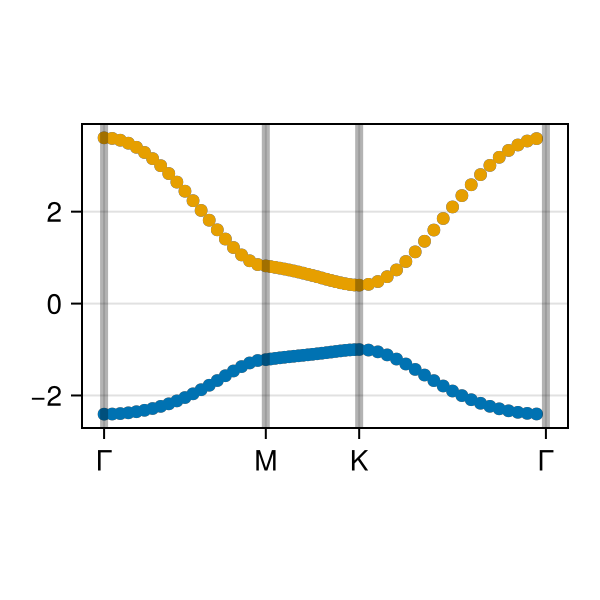


tb_model.k_data.basis_vec_list = [[6.283185307179586, -3.627598728468436], [0.0, 7.255197456936872]]
plot_bands(tb_model.Hk_crys, tb_model.k_data; k_path = [[0, 0], [1 / 2, 0], [2 / 3, 1 / 3], [0, 0]], k_path_name_list = ["Γ", "M", "K", "Γ"], nband_range = 1:l.nsub, nk = 20) = nothing
Test Summary:     | Total   Time
Haldane_honeycomb |     0  11.4s


Main.Lattice

In [ ]:
module Lattice

using LinearAlgebra
using Test

using YAN
YAN.load_global_method_table_for_pre_defined_op!()

using MLStyle
using CairoMakie


"""
Struct `Real_Space_Lattice{T}`
---
- fields:
    - `lattice_name::String`: name of lattice
    - `dim::Int`: dimension of lattice
    - `sample_size::Vector{Int}`
    - `cell_int_list::Vector{<:Vector}`: list of integer cell indices
    - `ncell::Int`: number of unit cells
    - `brav_vec_list::Vector{<:Vector}`: list of bravais vectors for real-space lattice (it can be _symbolic_ such as `MathExpr` from `YAN.jl`)
    - `cell_volume::T`: volume of the unit cell in real space
    - `nsub::Int`: number of sublattices in each unit cell
    - `sub_crys_list::Vector{<:Vector}`: list of sublattice positions _in crystal coordinates_ (it can be _symbolic_ such as `MathExpr` from `YAN.jl`)
    - `sub_name_list::Vector{String}`: list of sublattice names
    - `nsite::Int`: total number of sites in the lattice
    - `site_pos_list::Vector{Tuple{Vector{Int},Int}}`: list of site positions in each cell as `(cell_int, i_sub)`
    - `site_cart_list::Vector{<:Vector}`: list of site positions in cartesian coordinates (it can be _symbolic_ such as `MathExpr` from `YAN.jl`)
    - `site_pos_to_index_map::Dict{Tuple{Vector{Int},Int},Int}`: hashmap `(cell_int, i_sub) -> i_site`
"""
mutable struct Real_Space_Lattice{T}
    lattice_name::String
    dim::Int
    sample_size::Vector{Int}

    cell_int_list::Vector{<:Vector}
    ncell::Int

    brav_vec_list::Vector{<:Vector} # bravais vectors for real-space lattice
    cell_volume::T

    nsub::Int
    sub_crys_list::Vector{<:Vector} # sublattice positions in crystal coordinates
    sub_name_list::Vector{String}

    nsite::Int
    site_pos_list::Vector{Tuple{Vector{Int},Int}} # site positions in each cell as `(cell_int, i_sub)`
    site_cart_list::Vector{<:Vector} # site positions in cartesian coordinates
    site_pos_to_index_map::Dict{Tuple{Vector{Int},Int},Int} # hashmap `(cell_int, i_sub) -> i_site`
end


"""
Constructor for `Real_Space_Lattice`
---
- Named Args:
    - `brav_vec_list::Vector{<:Vector}`: list of bravais vectors for real-space lattice
    - `sample_size::Vector{Int}`: number of unit cells in each direction
    - `sub_crys_list::Vector{<:Vector}`: list of sublattice positions _in crystal coordinates_
    - `lattice_name::String`: name of lattice. If this is set to be `"square"`, `"honeycomb"`, `"kagome"`, and `"Lieb"`, it will override the above three arguments with the corresponding default values.)
"""
function initialize_real_space_lattice(;
    brav_vec_list::Vector{<:Vector}=[[1.0, 0.0], [0.0, 1.0]],
    sample_size::Vector{Int}=[2, 2],
    sub_crys_list::Vector{<:Vector}=[[0.0, 0.0]],
    lattice_name::String="",
)::Real_Space_Lattice
    (brav_vec_list, sub_crys_list) = @match lattice_name begin
        "square" => ([[1.0, 0.0], [0.0, 1.0]], [[0.0, 0.0]])
        "honeycomb" => ([[1.0, 0.0], [1 / 2, sqrt(3) / 2]], [[0.0, 0.0], [1 / 3, 1 / 3]])
        "kagome" => ([[1.0, 0.0], [1 / 2, sqrt(3) / 2]], [[0.0, 0.0], [1 / 2, 0], [0, 1 / 2]])
        "Lieb" => ([[1.0, 0.0], [0.0, 1.0]], [[0.0, 0.0], [1 / 2, 0], [0, 1 / 2]])
        _ => (brav_vec_list, sub_crys_list)
    end
    dim = length(brav_vec_list)

    brav_vec_mat = reduce(hcat, brav_vec_list) # `hcat()` forces `brav_vec` to be stored in columns in `brav_vec_mat`
    cell_volume = abs(det(brav_vec_mat))

    @assert dim == 2 || dim == 3
    @assert length(brav_vec_list) == length(sample_size)
    nsub = length(sub_crys_list)

    cell_int_list = Iterators.product([0:(Ni-1) for Ni in sample_size]...) .|> collect |> vec
    ncell = length(cell_int_list)

    @assert all(length.(sub_crys_list) == [dim for _ in 1:nsub])
    sub_name_list = [string("A", i) for i in 1:nsub] # the default name 


    site_pos_list = [(cell_int, i_sub) for cell_int in cell_int_list for i_sub in 1:nsub]
    nsite = length(site_pos_list)
    site_cart_list = [sum(brav_vec_list .* (cell_int + sub_crys_list[i_sub])) for (cell_int, i_sub) in site_pos_list]

    site_pos_to_index_map = Dict(zip(site_pos_list, 1:nsite))

    return Real_Space_Lattice{typeof(cell_volume)}(
        lattice_name,
        dim,
        sample_size,
        cell_int_list,
        ncell,
        brav_vec_list,
        cell_volume,
        nsub,
        sub_crys_list,
        sub_name_list,
        nsite,
        site_pos_list,
        site_cart_list,
        site_pos_to_index_map,
    )
end

"""
Struct `Real_Space_TightBinding_Model{T,U}`
---
for real-space hopping tight-binding model.
- Fields:
    - `lattice::Real_Space_Lattice{T}`: the underlying real-space lattice
    - `model_name::String`: name of the tight-binding model
    - `pbc_indicator::Vector{Bool}`: whether to apply periodic boundary condition in direction-i
    - `input_hopping_map::Dict{Tuple{Tuple{Vector{Int},Int},Tuple{Vector{Int},Int}},U}`: hashmap `(cell_int, i_sub) -> t`. This includes hoppings within and across unit cells. Hermicity is already implemented when building the `input_hopping_map`
    - `full_hopping_map::Dict{Tuple{Tuple{Vector{Int},Int},Tuple{Vector{Int},Int}},U}`: hashmap `(cell_int, i_sub) -> t`. This includes and expands ALL hoppings of the model. Translation symmetry is already implemented for bulk hopping terms
    - `H_hop::Function`: real-space hopping Hamiltonian (for edge-mode calculation)
"""
mutable struct Real_Space_TightBinding_Model{T,U}
    lattice::Real_Space_Lattice{T}
    model_name::String

    pbc_indicator::Vector{Bool} # whether to apply periodic boundary condition in direction-i

    input_hopping_map::Dict{Tuple{Tuple{Vector{Int},Int},Tuple{Vector{Int},Int}},U} # hashmap `(cell_int, i_sub) -> t`. This includes hoppings within and across unit cells. Hermicity is already implemented when building the `input_hopping_map`
    full_hopping_map::Dict{Tuple{Tuple{Vector{Int},Int},Tuple{Vector{Int},Int}},U} # hashmap `(cell_int, i_sub) -> t`. This includes and expands ALL hoppings of the model. Translation symmetry is already implemented for bulk hopping terms

    H_hop::Function # real-space hopping Hamiltonian (for edge-mode calculation)
end

"""
Constructor for `Real_Space_TightBinding_Model`
---
- Args:
    - `lattice::Real_Space_Lattice{T}`: the underlying real-space lattice
- Named Args:
    - `model_name::String`: name of the tight-binding model
    - `pbc_indicator::Vector{Bool}`: whether to apply periodic boundary condition in direction-i
"""
function initialize_real_space_tightbinding_model(lattice::Real_Space_Lattice{T};
    model_name::String="",
    pbc_indicator::Vector{Bool},
)::Real_Space_TightBinding_Model where {T,U}
    @assert length(pbc_indicator) == lattice.dim

    input_hopping_map = Dict{Tuple{Tuple{Vector{Int},Int},Tuple{Vector{Int},Int}},Number}()
    full_hopping_map = Dict{Tuple{Tuple{Vector{Int},Int},Tuple{Vector{Int},Int}},Number}()

    function H_hop end

    return Real_Space_TightBinding_Model(
        lattice,
        model_name,
        pbc_indicator,
        input_hopping_map,
        full_hopping_map,
        H_hop
    )
end




"""
Add One Hopping Term to `Real_Space_TightBinding_Model`
---
- Args:
    - `tb_model::Real_Space_TightBinding_Model`: the real-space tight-binding model to which the hopping term will be added
    - `input_hopping_term::Pair{Tuple{Tuple{Vector{Int64},Int64},Tuple{Vector{Int64},Int64}},T}`: the input hopping term in the form of `((cell_from, sub_from), (cell_to, sub_to)) => hopping_strength`. Note: it also applies to chemical potentials, when `cell_from == cell_to` and `sub_from == sub_to`.
- Named Args:
    - `is_hermitian::Bool=true`: whether to add the Hermitian conjugate of the input hopping term to the model
"""
function add_hopping_term!(
    tb_model::Real_Space_TightBinding_Model,
    input_hopping_term::Pair{Tuple{Tuple{Vector{Int64},Int64},Tuple{Vector{Int64},Int64}},T};
    is_hermitian::Bool=true,
) where T
    nsub = tb_model.lattice.nsub

    let (((cell_from, sub_from), (cell_to, sub_to)), hopping_strength) = input_hopping_term
        # check the validity of input hopping term
        @assert sub_from in 1:nsub && sub_to in 1:nsub "The input sublattice indices for `input_hopping_map`=$(input_hopping_term) is invalid for `sample_size`=$(tb_model.lattice.sample_size)!"
        # @assert all(0 .<= cell_from .<= (tb_model.lattice.sample_size .- 1)) && all(0 .<= cell_to .<= (tb_model.lattice.sample_size .- 1)) "The input cell indices for `input_hopping_map`=$(input_hopping_term) is invalid for `sample_size`=$(tb_model.lattice.sample_size)!"

        if haskey(tb_model.input_hopping_map, ((cell_from, sub_from), (cell_to, sub_to)))
            @warn "The input hopping term `$(input_hopping_term)` already exists in `input_hopping_map`! The old hopping term will be overwritten!"
        end

        tb_model.input_hopping_map[((cell_from, sub_from), (cell_to, sub_to))] = hopping_strength
        if is_hermitian
            tb_model.input_hopping_map[((cell_to, sub_to), (cell_from, sub_from))] = conj(hopping_strength)
        end

        # generate all bulk hopping terms using translation symmetry
        cell_diff = cell_to - cell_from
        for cell_int in tb_model.lattice.cell_int_list
            new_cell_from = cell_int
            new_cell_to = cell_int + cell_diff
            for i in 1:tb_model.lattice.dim
                if tb_model.pbc_indicator[i] # handle periodic boundary condition
                    new_cell_to[i] = new_cell_to[i] % tb_model.lattice.sample_size[i]
                end
            end
            if all(0 .<= new_cell_to .<= (tb_model.lattice.sample_size .- 1))
                tb_model.full_hopping_map[((new_cell_from, sub_from), (new_cell_to, sub_to))] = hopping_strength
                if is_hermitian
                    tb_model.full_hopping_map[((new_cell_to, sub_to), (new_cell_from, sub_from))] = conj(hopping_strength)
                end
            end
        end
        return nothing
    end
end

"""
Plot Hoppings and Sites of the `Real_Space_TightBinding_Model`
---
- Args:
    - `tb_model::Real_Space_TightBinding_Model`: the real-space tight-binding model to be visualized
---
Note: Hoppings can be overlapping if the model is complicated.
"""
function plot_real_space_tightbinding_model(tb_model::Real_Space_TightBinding_Model)
    l = tb_model.lattice
    @assert eltype(first(l.site_cart_list)) <: Real "The cartesian coordinates of sites must be real numbers for plotting!"
    fig = CairoMakie.Figure(size=(300, 300), backgroundcolor=:transparent)
    ax = @match l.dim begin
        2 => CairoMakie.Axis(fig[1, 1], backgroundcolor=:transparent; aspect=CairoMakie.DataAspect())
        3 => CairoMakie.Axis3(fig[1, 1], backgroundcolor=:transparent)
        _ => error("The dimension of the lattice must be 2 or 3!")
    end

    # plot all sites
    for (((cell_int), i_sub), i_site) in l.site_pos_to_index_map
        site_cart = l.site_cart_list[i_site]

        # color-coded by sublattice
        CairoMakie.scatter!(ax, site_cart...; markersize=20, color=CairoMakie.Cycled(i_sub))
    end

    # plot all real-space hoppings
    for (((cell_from, sub_from), (cell_to, sub_to)), t) in tb_model.full_hopping_map
        hopping_from_site_cart = l.site_cart_list[l.site_pos_to_index_map[(cell_from, sub_from)]]
        hopping_to_site_cart = l.site_cart_list[l.site_pos_to_index_map[(cell_to, sub_to)]]

        hopping_site_components = [reduce(hcat, [hopping_from_site_cart, hopping_to_site_cart])[d, :] for d in 1:l.dim] |> collect
        CairoMakie.lines!(ax, hopping_site_components...; linewidth=4, color=(:black, 0.3))
    end

    CairoMakie.display(fig)
    return nothing
end

"""
Struct `Uniform_Grids{T,U}`
---
mostly for k-space lattice. It can either be constructed independently, or from the real-space lattice with all-direction periodic boundary conditions. Note: for the latter case the real-space sublattice degrees of freedom are transferred to the dimension of the single-particle k-space Hamiltonian, which should be handled elsewhere.
- Fields: 
    - `name::String`: name of the uniform grid
    - `dim::Int`: dimension of the uniform grid
    - `sample_size::Vector{Int}`
    - `basis_vec_list::Vector{<:Vector}`: for k-space lattice, this is just the reciprocal vectors
    - `cell_volume::T`: volume of the unit cell for the uniform grid (please distinguish from the real space cell-volume when the uniform grid is for momentum space!)
    - `twisted_phases_over_2π::Vector{U}`: twisted phases (over 2π). This will shift the `site_crys_list`
    - `site_int_list::Vector{Vector{Int}}`
    - `site_int_to_index_map::Dict{Vector{Int},Int}`: hashmap `site_int -> i_site`
    - `site_crys_list::Vector{<:Vector}`: positions of sites in crystal coordinates
    - `site_cart_list::Vector{<:Vector}`: positions of sites in cartesian coordinates
    - `nsite::Int`
"""
struct Uniform_Grids{T,U}
    name::String
    dim::Int
    sample_size::Vector{Int} # number of k-points in each direction

    basis_vec_list::Vector{<:Vector} # for k-space lattice, this is just the reciprocal vectors
    cell_volume::T # volume of the unit cell in momentum space (please distinguish it from the volume of the unit cell in real space!)

    twisted_phases_over_2π::Vector{U} # twisted phases (over 2π). This will shift the `site_crys_list`
    site_int_list::Vector{Vector{Int}}
    site_int_to_index_map::Dict{Vector{Int},Int} # hashmap `site_int -> i_site`
    site_crys_list::Vector{<:Vector} # positions of sites in crystal coordinates
    site_cart_list::Vector{<:Vector} # positions of sites in cartesian coordinates

    nsite::Int
end

"""
Constructor of `Uniform_Grids`
---
- Named Args:
    - `basis_vec_list::Vector{<:Vector}`: list of basis vectors for the uniform grid
    - `sample_size::Vector{Int}`: number of k-points in each direction
    - `name::String=""`: name of the uniform grid
    - `twisted_phases_over_2π::Vector{U}`: twisted phases (over 2π). This will shift the `site_crys_list` as well as `site_cart_list`
"""
function initialize_uniform_grids(;
    basis_vec_list::Vector{<:Vector},
    sample_size::Vector{Int},
    name::String="",
    twisted_phases_over_2π::Vector{U}
)::Uniform_Grids where U
    dim = length(sample_size)
    @assert length(basis_vec_list) == dim "The length of `basis_vec_list` must be the same as the dimension of the uniform grid!"
    @assert all(length.(basis_vec_list) .== dim) "Every basis vector in `basis_vec_list` must have the same dimension as the uniform grid!"

    basis_vec_mat = reduce(hcat, basis_vec_list) # `hcat()` forces `basis_vec` to be stored in columns in `basis_vec_mat`
    cell_volume = abs(det(basis_vec_mat)) # volume of the unit cell in momentum space

    site_int_list = Iterators.product([0:(Ni-1) for Ni in sample_size]...) .|> collect |> vec
    nsite = length(site_int_list)
    site_int_to_index_map = Dict(zip(site_int_list, 1:nsite))

    site_crys_list = [((site_int + twisted_phases_over_2π) ./ sample_size) for site_int in site_int_list]
    site_cart_list = [sum(site_crys .* basis_vec_list) for site_crys in site_crys_list]

    return Uniform_Grids{typeof(cell_volume),U}(
        name,
        dim,
        sample_size,
        basis_vec_list,
        cell_volume,
        twisted_phases_over_2π,
        site_int_list,
        site_int_to_index_map,
        site_crys_list,
        site_cart_list,
        nsite
    )
end

"""
Constructor of `Uniform_Grids`
---
from `r_data::Real_Space_Lattice` satisfying PBC in ALL directions.
- Args:
    - `r_data::Real_Space_Lattice`: the underlying real-space lattice (with PBC in ALL directions)
- Named Args:
    - `twisted_phases_over_2π::Vector{U}`: twisted phases (over 2π). This will shift the `site_crys_list` as well as `site_cart_list`
"""
function initialize_uniform_grids(
    r_data::Real_Space_Lattice;
    twisted_phases_over_2π::Vector{U}
)::Uniform_Grids where U
    dim = r_data.dim
    sample_size = r_data.sample_size

    dual_basis_vec_mat = reduce(hcat, r_data.brav_vec_list) # for momentum-space lattice, the `dual_basis_vec_mat` is the real-space bravais vectors
    basis_vec_mat = 2π * inv(dual_basis_vec_mat)'

    cell_volume = abs(det(basis_vec_mat)) # volume of the unit cell in momentum space
    basis_vec_list = [basis_vec_mat[:, i] for i in 1:dim]

    site_int_list = Iterators.product([0:(Ni-1) for Ni in sample_size]...) .|> collect |> vec
    nsite = length(site_int_list)
    site_int_to_index_map = Dict(zip(site_int_list, 1:nsite))

    site_crys_list = [((site_int + twisted_phases_over_2π) ./ sample_size) for site_int in site_int_list]
    site_cart_list = [sum(site_crys .* basis_vec_list) for site_crys in site_crys_list]

    k_data = Uniform_Grids{typeof(r_data.cell_volume),T}(
        r_data.lattice_name,
        dim,
        sample_size,
        basis_vec_list,
        cell_volume,
        twisted_phases_over_2π,
        site_int_list,
        site_int_to_index_map,
        site_crys_list,
        site_cart_list,
        nsite
    )
end


mutable struct TightBinding_Model{T,P,U}
    model_name::String
    # params::Dict{promote_type(T, P, U, String),Float64}

    # tight-binding data 
    input_hopping_map::Dict{Tuple{Tuple{Vector{Int},Int},Tuple{Vector{Int},Int}},U} # hashmap `(cell_int, i_sub) -> t`. This includes hoppings within and across unit cells. Hermicity is already implemented when building the `input_hopping_map`
    full_hopping_map::Dict{Tuple{Tuple{Vector{Int},Int},Tuple{Vector{Int},Int}},U} # hashmap `(cell_int, i_sub) -> t`. This includes ALL hoppings of the model. Translation symmetry is already implemented for bulk hopping terms

    # r-data 
    r_data::Real_Space_Lattice{T}

    # k-data
    k_data::Uniform_Grids{T,P}

    # Hk_crys_symbolic::Function # k-space symbolic Hamiltonian function
    Hk_crys::Function # symbolic k-space Hamiltonian function
end


function initialize_tightbinding_model(
    real_space_tb_model::Real_Space_TightBinding_Model;
    model_name::String="",
    twisted_phases_over_2π::Vector{T}
)::TightBinding_Model where T
    @assert all(real_space_tb_model.pbc_indicator) "The `pbc_indicator` must be all `true` for constructing the k-space lattice from the real-space lattice!"
    @assert length(twisted_phases_over_2π) == real_space_tb_model.lattice.dim

    r_data = real_space_tb_model.lattice
    k_data = initialize_uniform_grids(r_data; twisted_phases_over_2π=twisted_phases_over_2π)

    # construct the k-space Hamiltonian function `Hk_crys`
    Hk_crys = (k_crys::Vector{T} where T) -> begin
        @assert length(k_crys) == r_data.dim
        Hk_crys_mat = zeros(YAN.MathExpr, r_data.nsub, r_data.nsub)
        for (((cell_from, sub_from), (cell_to, sub_to)), t) in real_space_tb_model.input_hopping_map # only sum over the input hopping terms!
            r_crys = (cell_to - cell_from) + (r_data.sub_crys_list[sub_to] - r_data.sub_crys_list[sub_from])

            # recall that we've already handled the hermicity when formatting the `input_hopping_map`
            Hk_crys_mat[sub_from, sub_to] += t * exp(im * 2π * dot(k_crys, r_crys)) # we do not bother to switch to cartesian coordinate for evaluation of the dot product here
        end
        Hk_crys_mat::Matrix{YAN.MathExpr}
    end

    return TightBinding_Model(
        model_name,
        real_space_tb_model.input_hopping_map,
        real_space_tb_model.full_hopping_map,
        r_data,
        k_data,
        Hk_crys
    )
end



"""
Plot Band Structure
---
with automatic scaling of `k_point_xs` based on each cartesian length of the k-path segments
- Args:
    - `Hk_crys::Function`: the k-space Hamiltonian function with `k_crys` input
    - `k_data::Uniform_Grids`: the k-space uniform grids
- Named Args:
    - `k_path::Vector{Vector{Float64}}`: a list turning k-points in crystal coordinates
    - `k_path_name_list::Vector{String}`: the names for turning points in `k_path`
    - `nband_range::Union{UnitRange{Int},Vector{Int}}`: the range or list of band indices to plot
    - `nk::Int`: number of k-points per path for plot
"""
function plot_bands(
    Hk_crys, k_data::Uniform_Grids;
    k_path::Vector{<:Vector{<:Real}},
    k_path_name_list::Vector{String}=Vector{String}(),
    nband_range::Union{UnitRange{Int},Vector{Int}}=1:1,
    nk::Int=30
)
    dim = k_data.dim
    @assert length(k_path) >= 2 "The input `k_path` must contain at least two k-points to form a path!"
    @assert all(length(k_crys) == dim for k_crys in k_path) "Every k-point in `k_path` must have the same dimension as the k-space lattice!"
    if !isempty(k_path_name_list)
        @assert length(k_path_name_list) == length(k_path) "Every k-point in `k_path` must have a corresponding name in `k_path_name_list`!"
    end


    function prepare_band_plot_data(;
        k_path::Vector{Vector{Float64}}, nk::Int=20
    )
        k_crys_list = Vector{Vector{Float64}}()
        vline_pos_list = Vector{Float64}() # the vertical line positions for plot
        k_point_xs = Vector{Float64}() # the x-coordinates of k-points for plot

        push!(vline_pos_list, 0.0) # the first vline
        push!(k_point_xs, 0.0) # the first k-point x-coordinate

        for k_path_id in 1:(length(k_path)-1)
            k_head_crys = k_path[k_path_id]
            k_tail_crys = k_path[k_path_id+1]

            k_head_cart = sum(k_head_crys .* k_data.basis_vec_list)
            k_tail_cart = sum(k_tail_crys .* k_data.basis_vec_list)
            δk_cart = norm(k_tail_cart - k_head_cart) / nk
            for i in 0:(nk-1)
                push!(k_crys_list, k_head_crys .+ (k_tail_crys .- k_head_crys) .* (i / nk))
                push!(k_point_xs, k_point_xs[end] + δk_cart)
            end
            push!(vline_pos_list, k_point_xs[end]) # the last vline
        end
        return (k_crys_list, vline_pos_list, k_point_xs)
    end
    (k_crys_list, vline_pos_list, k_point_xs) = prepare_band_plot_data(; k_path=k_path, nk=nk)

    fig = CairoMakie.Figure(size=(300, 300), backgroundcolor=:transparent)

    vline_ticks = if !isempty(k_path_name_list)
        (vline_pos_list, k_path_name_list)
    else
        (vline_pos_list, ["A_$(i)" for i in eachindex(vline_pos_list)])
    end

    ax = CairoMakie.Axis(fig[1, 1],
        backgroundcolor=:transparent,
        aspect=1.6,
        xticks=vline_ticks,
    )

    for (k_crys, k_point_x) in zip(k_crys_list, k_point_xs)
        Hk_mat = Hk_crys(k_crys)
        @assert all(band_index <= size(Hk_mat, 1) for band_index in nband_range)
        @assert norm(Hk_mat - 1 / 2 * (Hk_mat + Hk_mat')) < 1.0E-8 "The k-space Hamiltonian is not Hermitian at `k_crys=$(k_crys)`!"
        eig_vals = eigen(Hermitian(Hk_mat)).values
        for i_band in nband_range
            CairoMakie.scatter!(ax, k_point_x, eig_vals[i_band]; color=CairoMakie.Cycled(i_band))
        end
    end

    for vline_pos in vline_pos_list
        CairoMakie.vlines!(ax, vline_pos; color=(:black, 0.3), linewidth=4)
    end

    display(fig)
    return nothing
end

# @testset "Graphene" begin
#     YAN.@vars a b

#     a = 1
#     l = initialize_real_space_lattice(; brav_vec_list=[[a, 0], [a / 2, sqrt(3) * a / 2]], sample_size=[2, 2], sub_crys_list=[[0, 0], [1 / 3, 1 / 3]])
#     # l = initialize_real_space_lattice(lattice_name="honeycomb", sample_size=[3, 2])
#     real_space_tb_model = initialize_real_space_tightbinding_model(l; model_name="test", pbc_indicator=[true, true])

#     YAN.@vars t μ
#     # add chemical potential terms
#     for i_sub in 1:2
#         add_hopping_term!(real_space_tb_model, (([0, 0], i_sub), ([0, 0], i_sub)) => μ; is_hermitian=false)
#     end

#     # add nearest-neighbor (nn) hoppings
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, 0], 2)) => t; is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 2), ([1, 0], 1)) => t; is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 2), ([0, 1], 1)) => t; is_hermitian=true)


#     plot_real_space_tightbinding_model(real_space_tb_model)

#     tb_model = initialize_tightbinding_model(real_space_tb_model; twisted_phases_over_2π=[0, 0])
#     @show tb_model.input_hopping_map
#     @show tb_model.k_data.basis_vec_list

#     Hk_crys = tb_model.Hk_crys
#     tb_model.Hk_crys = (k_crys::Vector{Float64}) -> begin
#         # @vars my_conj(),x
#         Hk_mat = YAN.subs.(Hk_crys(k_crys), Ref(Dict(a => 1.0, t => 1.0, μ => 0.0)))
#         @assert length(YAN.free_symbols(Hk_mat)) == 0 "The k-space Hamiltonian still contains symbolic variables after substitution!"
#         # Matrix{ComplexF64}(Hk_mat)
#         Hk_mat
#     end

#     @show plot_bands(
#         tb_model.Hk_crys,
#         tb_model.k_data;
#         k_path=[[0, 0], [1 / 2, 0], [2 / 3, 1 / 3], [0, 0]],
#         k_path_name_list=["Γ", "M", "K", "Γ"],
#         nband_range=1:l.nsub,
#         nk=30
#     )
# end

@testset "Haldane_honeycomb" begin
    YAN.@vars a b

    a = 1
    l = initialize_real_space_lattice(; brav_vec_list=[[a, 0], [a / 2, sqrt(3) * a / 2]], sample_size=[3, 3], sub_crys_list=[[0, 0], [1 / 3, 1 / 3]])
    # l = initialize_real_space_lattice(lattice_name="honeycomb", sample_size=[3, 2])
    real_space_tb_model = initialize_real_space_tightbinding_model(l; model_name="test", pbc_indicator=[true, true])

    YAN.@vars t t′ ϕ μ
    # add chemical potential terms
    add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, 0], 1)) => μ; is_hermitian=false)
    add_hopping_term!(real_space_tb_model, (([0, 0], 2), ([0, 0], 2)) => -μ; is_hermitian=false)

    # add nearest-neighbor (nn) hoppings
    YAN.@vars t
    add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, 0], 2)) => t; is_hermitian=true)
    add_hopping_term!(real_space_tb_model, (([0, 0], 2), ([1, 0], 1)) => t; is_hermitian=true)
    add_hopping_term!(real_space_tb_model, (([0, 0], 2), ([0, 1], 1)) => t; is_hermitian=true)

    # add next-nearest-neighbor (nnn) hoppings
    YAN.@vars t′ ϕ
    add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([1, 0], 1)) => t′ * exp(-im * ϕ); is_hermitian=true)
    add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, 1], 1)) => t′ * exp(im * ϕ); is_hermitian=true)
    add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([-1, 1], 1)) => t′ * exp(-im * ϕ); is_hermitian=true)

    add_hopping_term!(real_space_tb_model, (([0, 0], 2), ([1, 0], 2)) => t′ * exp(im * ϕ); is_hermitian=true)
    add_hopping_term!(real_space_tb_model, (([0, 0], 2), ([0, 1], 2)) => t′ * exp(-im * ϕ); is_hermitian=true)
    add_hopping_term!(real_space_tb_model, (([0, 0], 2), ([-1, 1], 2)) => t′ * exp(im * ϕ); is_hermitian=true)

    # plot_real_space_tightbinding_model(real_space_tb_model)

    tb_model = initialize_tightbinding_model(real_space_tb_model; twisted_phases_over_2π=[0, 0])
    @show tb_model.input_hopping_map
    @show tb_model.k_data.basis_vec_list

    Hk_crys = tb_model.Hk_crys
    tb_model.Hk_crys = (k_crys::Vector{Float64}) -> begin
        # @vars my_conj(),x
        Hk_mat = YAN.subs.(Hk_crys(k_crys), Ref(Dict(a => 1.0, t => 1.0, t′ => 0.2, ϕ => π / 3, μ => 0.2)))
        @assert length(YAN.free_symbols(Hk_mat)) == 0 "The k-space Hamiltonian still contains symbolic variables after substitution!"
        Matrix{ComplexF64}(Hk_mat)
    end

    @show plot_bands(
        tb_model.Hk_crys,
        tb_model.k_data;
        k_path=[[0, 0], [1 / 2, 0], [2 / 3, 1 / 3], [0, 0]],
        k_path_name_list=["Γ", "M", "K", "Γ"],
        nband_range=1:l.nsub,
        nk=20
    )
end

# @testset "kagome" begin
#     YAN.@vars a b

#     a = 1
#     l = initialize_real_space_lattice(; brav_vec_list=[[a, 0], [a / 2, sqrt(3) * a / 2]], sample_size=[4, 3], sub_crys_list=[[0, 0], [1 / 2, 0], [0, 1 / 2]])
#     # l = initialize_real_space_lattice(lattice_name="honeycomb", sample_size=[3, 2])
#     real_space_tb_model = initialize_real_space_tightbinding_model(l; model_name="test", pbc_indicator=[true, true])

#     YAN.@vars t μ
#     # add chemical potential terms 
#     for i_sub in 1:3
#         add_hopping_term!(real_space_tb_model, (([0, 0], i_sub), ([0, 0], i_sub)) => μ; is_hermitian=false)
#     end

#     # add nearest-neighbor (nn) hoppings
#     YAN.@vars t
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, 0], 2)) => t; is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, 0], 3)) => t; is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 2), ([0, 0], 3)) => t; is_hermitian=true)

#     add_hopping_term!(real_space_tb_model, (([0, 0], 2), ([1, 0], 1)) => t; is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 3), ([0, 1], 1)) => t; is_hermitian=true)

#     add_hopping_term!(real_space_tb_model, (([0, 0], 2), ([1, -1], 3)) => t; is_hermitian=true)

#     plot_real_space_tightbinding_model(real_space_tb_model)


#     tb_model = initialize_tightbinding_model(real_space_tb_model; twisted_phases_over_2π=[0, 0])
#     @show tb_model.input_hopping_map
#     @show tb_model.k_data.basis_vec_list

#     Hk_crys = tb_model.Hk_crys
#     tb_model.Hk_crys = (k_crys::Vector{Float64}) -> begin
#         # @vars my_conj(),x
#         Hk_mat = YAN.subs.(Hk_crys(k_crys), Ref(Dict(a => 1.0, t => 1.0, μ => 0.0)))
#         @assert length(YAN.free_symbols(Hk_mat)) == 0 "The k-space Hamiltonian still contains symbolic variables after substitution!"
#         # Matrix{ComplexF64}(Hk_mat)
#         Hk_mat
#     end

#     @show plot_bands(
#         tb_model.Hk_crys,
#         tb_model.k_data;
#         k_path=[[0, 0], [1 / 2, 0], [2 / 3, 1 / 3], [0, 0]],
#         k_path_name_list=["Γ", "M", "K", "Γ"],
#         nband_range=1:l.nsub,
#         nk=30
#     )


# end

# @testset "Singlular Flat Band in `PhysRevLett.134.196501`" begin
#     YAN.@vars a b

#     a = 1
#     l = initialize_real_space_lattice(; brav_vec_list=[[3 / 2 * a, sqrt(3) / 2 * a], [0, sqrt(3) * a]], sample_size=[3, 3], sub_crys_list=[[0, 0], [2 / 3, -1 / 3], [1 / 3, 1 / 3]])
#     # l = initialize_real_space_lattice(lattice_name="honeycomb", sample_size=[3, 2])
#     real_space_tb_model = initialize_real_space_tightbinding_model(l; model_name="test", pbc_indicator=[true, true])

#     YAN.@vars εA t t′ η ϕ
#     # add chemical potential for A-orbital
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, 0], 1)) => εA; is_hermitian=false)

#     # add nearest-neighbor (nn) hoppings
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, 0], 2)) => η * t * exp(-im * 2 * ϕ); is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, 0], 3)) => t * exp(im * 2 * ϕ); is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([-1, 1], 2)) => t; is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([-1, 0], 3)) => η * t * exp(-im * 2 * ϕ); is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([-1, 0], 2)) => t * exp(im * 2 * ϕ); is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, -1], 3)) => t; is_hermitian=true)


#     plot_real_space_tightbinding_model(real_space_tb_model)

#     tb_model = initialize_tightbinding_model(real_space_tb_model; twisted_phases_over_2π=[0, 0])

#     Hk_crys = tb_model.Hk_crys
#     tb_model.Hk_crys = (k_crys::Vector{Float64}) -> begin
#         # @vars my_conj(),x
#         Hk_mat = YAN.subs.(Hk_crys(k_crys), Ref(Dict(a => 1.0, t => 1.0, ϕ => π / 3, η => 1.0, εA => 4.0)))
#         @assert length(YAN.free_symbols(Hk_mat)) == 0 "The k-space Hamiltonian still contains symbolic variables after substitution!"
#         Matrix{ComplexF64}(Hk_mat)
#     end

#     @show plot_bands(
#         tb_model.Hk_crys,
#         tb_model.k_data;
#         k_path=[[2 / 3, 1 / 3], [0, 0], [1 / 3, 2 / 3], [2 / 3, 1 / 3]],
#         k_path_name_list=["K'", "Γ", "K", "K'"],
#         nband_range=1:l.nsub,
#         nk=30
#     )
# end

# @testset "Singlular Flat Band in `PhysRevLett.134.196501` with Anisotropic hoppings in `arViv:2505.09009v2`" begin
#     YAN.@vars a b

#     a = 1
#     l = initialize_real_space_lattice(; brav_vec_list=[[3 / 2 * a, sqrt(3) / 2 * a], [0, sqrt(3) * a]], sample_size=[3, 3], sub_crys_list=[[0, 0], [2 / 3, -1 / 3], [1 / 3, 1 / 3]])
#     # l = initialize_real_space_lattice(lattice_name="honeycomb", sample_size=[3, 2])
#     real_space_tb_model = initialize_real_space_tightbinding_model(l; model_name="test", pbc_indicator=[true, true])

#     YAN.@vars εA t t′ η ϕ
#     # add chemical potential for A-orbital
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, 0], 1)) => εA; is_hermitian=false)

#     # add nearest-neighbor (nn) hoppings
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, 0], 2)) => η * t * exp(-im * 2 * ϕ); is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, 0], 3)) => t * exp(im * 2 * ϕ); is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([-1, 1], 2)) => t; is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([-1, 0], 3)) => η * t * exp(-im * 2 * ϕ); is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([-1, 0], 2)) => t * exp(im * 2 * ϕ); is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, -1], 3)) => t; is_hermitian=true)


#     plot_real_space_tightbinding_model(real_space_tb_model)

#     tb_model = initialize_tightbinding_model(real_space_tb_model; twisted_phases_over_2π=[0, 0])

#     Hk_crys = tb_model.Hk_crys
#     tb_model.Hk_crys = (k_crys::Vector{Float64}) -> begin
#         # @vars my_conj(),x
#         Hk_mat = YAN.subs.(Hk_crys(k_crys), Ref(Dict(a => 1.0, t => 1.0, ϕ => π / 3, η => 0.4, εA => 4.0)))
#         @assert length(YAN.free_symbols(Hk_mat)) == 0 "The k-space Hamiltonian still contains symbolic variables after substitution!"
#         Matrix{ComplexF64}(Hk_mat)
#     end

#     @show plot_bands(
#         tb_model.Hk_crys,
#         tb_model.k_data;
#         k_path=[[2 / 3, 1 / 3], [0, 0], [1 / 2, 1 / 2], [2 / 3, 1 / 3]],
#         k_path_name_list=["K'", "Γ", "M", "K'"],
#         nband_range=1:2, # we only plot the two lowest bands here
#         nk=30
#     )
# end

# @testset "Two-orbital Effective Model in `arViv:2505.09009v2`" begin
#     YAN.@vars a b

#     a = 1
#     l = initialize_real_space_lattice(; brav_vec_list=[[3 / 2 * a, sqrt(3) / 2 * a], [0, sqrt(3) * a]], sample_size=[3, 3], sub_crys_list=[[2 / 3, -1 / 3], [1 / 3, 1 / 3]]) # we remove atom-A here 
#     real_space_tb_model = initialize_real_space_tightbinding_model(l; model_name="test", pbc_indicator=[true, true])

#     YAN.@vars εA t t′ η ϕ

#     # add effecitive nn-hoppings
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, 0], 2)) => η * t′; is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, -1], 2)) => η * t′; is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 2), ([-1, 1], 1)) => t′; is_hermitian=true)

#     # add effective nnn-hoppings
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([-1, 1], 1)) => η * t′ * exp(-im * 2 * ϕ); is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([-1, 0], 1)) => η * t′ * exp(im * 2 * ϕ); is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([0, 1], 1)) => t′ * exp(im * 2 * ϕ); is_hermitian=true)

#     add_hopping_term!(real_space_tb_model, (([0, 0], 2), ([1, -1], 2)) => η * t′ * exp(im * 2 * ϕ); is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 2), ([1, 0], 2)) => η * t′ * exp(-im * 2 * ϕ); is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, 0], 2), ([0, -1], 2)) => t′ * exp(-im * 2 * ϕ); is_hermitian=true)

#     # add effective nnnn-hoppings
#     add_hopping_term!(real_space_tb_model, (([0, 0], 1), ([-1, 0], 2)) => -η^2 * t′; is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([0, -1], 2), ([-1, 1], 1)) => -t′; is_hermitian=true)
#     add_hopping_term!(real_space_tb_model, (([-1, 0], 1), ([0, 0], 2)) => -t′; is_hermitian=true)



#     plot_real_space_tightbinding_model(real_space_tb_model)

#     tb_model = initialize_tightbinding_model(real_space_tb_model; twisted_phases_over_2π=[0, 0])

#     Hk_crys = tb_model.Hk_crys
#     tb_model.Hk_crys = (k_crys::Vector{Float64}) -> begin
#         # @vars my_conj(),x
#         Hk_mat = YAN.subs.(Hk_crys(k_crys), Ref(Dict(a => 1.0, t′ => -1 / 8, ϕ => π / 3, η => 0.4)))
#         @assert length(YAN.free_symbols(Hk_mat)) == 0 "The k-space Hamiltonian still contains symbolic variables after substitution!"
#         Matrix{ComplexF64}(Hk_mat)
#     end

#     @show plot_bands(
#         tb_model.Hk_crys,
#         tb_model.k_data;
#         k_path=[[2 / 3, 1 / 3], [0, 0], [1 / 2, 1 / 2], [1 / 3, 2 / 3]],
#         k_path_name_list=["K", "Γ", "M", "K'"],
#         nband_range=1:l.nsub,
#         nk=30
#     )
# end


end # end module